### 0.0 Introduction

#### This notebook uses data scraped from kickstarter by webrobots (found here : https://webrobots.io/kickstarter-datasets/). Performs an exploratory clustering analysis on these data. It uses word2vec to transform the text data in this set into a 7 dimensional vector.

In [75]:
import requests
import random
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
import scipy
import pickle
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
pd.set_option('display.max_columns', 1000)

## 1.0 Importing Data and Selecting Features.

### I will combine scraped data I have access to from 2022 and 2023, using the os library.

In [4]:
month_folders = ['April2023', 'August2023', 'February2023', 'January2022',
                 'January2023', 'July2023', 'June2023', 'March2023', 'May2023', 'September2023'];

In [5]:
raw_df = pd.DataFrame();

current_paths = [];
for month in month_folders:
    current_paths = current_paths + [join(month, x) for x in listdir(month) if '.csv' in x]

for current_path in current_paths:
    df_temp = pd.read_csv(current_path);
    raw_df = pd.concat([raw_df, df_temp])

raw_df = raw_df.reset_index(drop = True)

### This is what the raw data look like. I will begin paring down the columns that I would like to use.

In [6]:
raw_df.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,location,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,friends,is_backing,is_starred,permissions
0,230,I know how difficult it is to gain any experie...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",11211.0,GB,the United Kingdom,1389127645,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,£,False,USD,1393111179,False,1.238278,1999.0,542567707,False,1390519179,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",Cisco CCNA and CCNA Security for the Real Worl...,"{""key"":""assets/011/631/975/49f72198be90d30752b...",6746.0,"{""id"":839405,""project_id"":839405,""state"":""inac...",cisco-ccna-and-ccna-security-for-the-real-worl...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1393111180,1.648362,"{""web"":{""project"":""https://www.kickstarter.com...",1.661914,11119.847421,international,NaN,NaN,NaN,NaN


In [7]:
df_selected = raw_df[['backers_count', 'blurb',
                      'category', 'country', 'creator',
                      'currency', 'currency_trailing_code',
                      'disable_communication', 'fx_rate',
                      'goal', 'is_starrable', 'name',
                      'pledged', 'slug', 'spotlight',
                      'staff_pick', 'state', 'usd_exchange_rate',
                      'usd_pledged']]

### I use ast.literal_eval to esaily extract the cateogory from the json like format that it exists in natively, whith the raw data column, "category."

In [8]:
df_selected.loc[:,'category'] = (df_selected.copy()).apply(lambda x : ast.literal_eval(x['category'])['name'], axis = 1)

In [9]:
df_selected.head(1)

,backers_count,blurb,category,country,creator,currency,currency_trailing_code,disable_communication,fx_rate,goal,is_starrable,name,pledged,slug,spotlight,staff_pick,state,usd_exchange_rate,usd_pledged
0,230,I know how difficult it is to gain any experie...,Software,GB,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,False,False,1.238278,1999.0,False,Cisco CCNA and CCNA Security for the Real Worl...,6746.0,cisco-ccna-and-ccna-security-for-the-real-worl...,True,False,successful,1.661914,11119.847421


## 1.1 Word Processing

### I want to do a word frequency analysis within the clusters result from the analysis that is to come. So I will combine the "blurb," "name," and "slug" columns for each data entry into a single "sentence." I will analyze the linquistic content of these sentences at the end of the analysis.

In [10]:
corpus = [];
corpus_index = []

for index, row in df_selected.iterrows():
    try:
        sentence = [row['name'] + '. ' + row['slug'] + '. ' + row['blurb']];
        corpus = corpus + sentence;
        corpus_index.append(index);
    
    except:
        continue;

### I like to save data structures that take a little bit of time to make so I do not have to recalculate them multiple times.

In [11]:
with open('kickstarter-sentiment-analysis_corpus.pickle', 'wb') as handle:
    pickle.dump(corpus, handle);

In [12]:
with open('kickstarter-sentiment-analysis_corpus.pickle', 'rb') as handle:
    corpus = pickle.load(handle);

### To make manipulating the corpus easier, later on, I will make a data frame out of it. I will run simple_preprocess, from gensim, on each "sentence" so that the word analysis is easier.

In [13]:
df_corpus = pd.DataFrame({'sentences' : corpus}, index = corpus_index)

In [14]:
df_corpus_processed = df_corpus.copy()
df_corpus_processed.loc[:, 'sentences'] = df_corpus['sentences'].apply(lambda x : simple_preprocess(x))

In [15]:
df_corpus.to_csv('kickstarter-sentiment-analysis_df_corpus.pickle', index = False);
df_corpus = pd.read_csv('kickstarter-sentiment-analysis_df_corpus.pickle');

### Combining the corpus data frame with the numerical data, now I have a nice object with the numerical data and the preprocessed sentences for each data point.

In [16]:
df_with_sentences = pd.concat([df_selected[['backers_count',
                                         'category',
                                         'fx_rate',
                                         'goal',
                                         'pledged',
                                         'state']].loc[df_corpus.index],df_corpus_processed], axis = 1)

In [17]:
df_with_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences
0,230.0,Software,1.238278,1999.0,6746.0,successful,"[cisco, ccna, and, ccna, security, for, the, r..."
1,34.0,Software,1.238278,200.0,1079.0,successful,"[strong, file, encryption, tool, strong, file,..."


## 1.2 Mapping Categorical Data to Numerical Data

### I will run the clustering alogithm on numerical data only, to begin. After converting all of the currency values to dollar equivalents, I will make a function that maps the "state" of the kickstarter campagin -- submitted, failed, successful etc -- to a number from -3.0 to 3.0. I will do something similar with the "category" field, instead assigning it an ordinal value from 0 to N-1 where N is the number of different categories.

In [18]:
df_with_sentences['goal_usd'] = df_with_sentences['goal'] * df_with_sentences['fx_rate']

In [19]:
df_with_sentences['pledged_usd'] = df_with_sentences['pledged'] * df_with_sentences['fx_rate']

In [21]:
df_with_sentences[['backers_count', 'category', 'fx_rate', 'state', 'sentences', 'goal_usd', 'pledged_usd']].to_csv('./kickstarter-sentiment-analysis_usd-preprocessed-with-sentences.csv', index = False);

In [22]:
df_cluster = df_with_sentences[['backers_count', 'category', 'fx_rate', 'pledged', 'state','goal_usd', 'pledged_usd']]

In [23]:
def map_state_to_number(state_string):
    lookup = {"failed": -3.0,
              "canceled": -2.0,
              "suspended" : -1.0,
              "submitted" : 0.0,
              "started" : 1.0,
              "live" : 2.0,
              "successful" : 3.0};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [24]:
category_lookup = {}
for index, item in enumerate(list(set(df_with_sentences['category']))):
    category_lookup.update({item: index})

In [25]:
def map_category_to_number(state_string, category_lookup):
    try:
        value = category_lookup[state_string];
    except:
        value = -1.1;
    
    return value

In [26]:
df_cluster_copy = df_cluster.copy()

In [27]:
df_cluster_copy.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd
0,230.0,Software,1.238278,6746.0,successful,2475.318022,8353.424400
1,34.0,Software,1.238278,1079.0,successful,247.655630,1336.102124


In [28]:
df_cluster_copy['state'] = df_cluster['state'].apply(lambda x : map_state_to_number(x))

In [29]:
df_cluster_copy['category'] = df_cluster['category'].apply(lambda x : map_category_to_number(x, category_lookup))

array([[<Axes: title={'center': 'state'}>]], dtype=object)

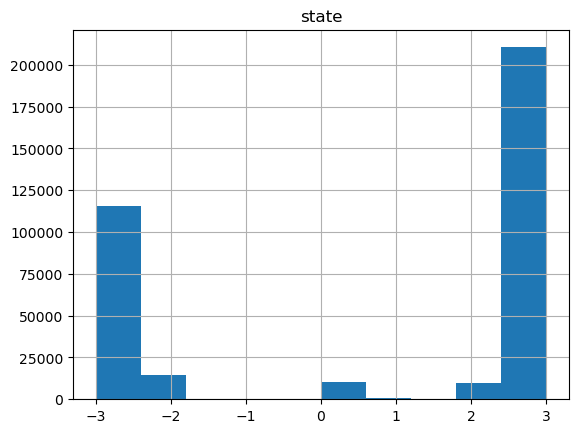

In [30]:
df_cluster_copy.hist(column = 'state', grid = True)

array([[<Axes: title={'center': 'category'}>]], dtype=object)

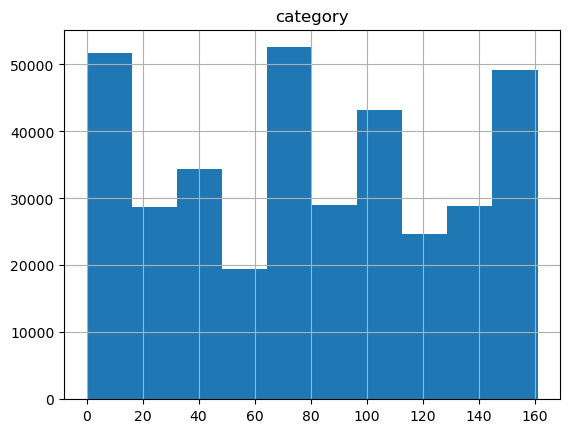

In [31]:
df_cluster_copy.hist(column = 'category', grid = True)

In [32]:
df_cluster_copy.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd
0,230.0,11,1.238278,6746.0,3.0,2475.318022,8353.424400
1,34.0,11,1.238278,1079.0,3.0,247.655630,1336.102124


In [33]:
df_cluster_copy.to_csv("./kickstarter-sentiment-analysis_usd-numerical-clustering-dataset.csv", index = False)

## 2.0 Clustering

### Now the clustering data are all ready to go. I will use sklean's KMeans implementation to do the cluster analysis.

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [35]:
df_cluster = pd.read_csv("./kickstarter-sentiment-analysis_usd-numerical-clustering-dataset.csv")

In [36]:
df_cluster = df_cluster.dropna(axis = 0)

## 2.1 Defining Necessary Functions for Clustering

### In order to determine which K is best of the algorithm (how many centroids to use) I will define a function that runs the clustering algorithm and then creates silhouette plots. I will use the number of centroids which produce a silhouette plot with a high average silhouette score and well behaved individual silhoutter scores. This is somewhat subject.

In [65]:
def silhouette_plot(silhouette_values, silhouette_average, labels):
    
    fig, ax = plt.subplots();
    fig.set_size_inches(6,6);
    
    ax.set_xlim([-0.1, 1.0]);
    ax.set_ylim([0, len(silhouette_values) + (len(set(labels)) + 1) * 10])
    
    cluster_plot_lower_y_value = 10;
    for label_value in list(set(labels)):
        label_n_silhouette_values = sorted([silhouette_values[i] for i in range(len(labels)) if labels[i] == label_value]);
        
        size_of_n_cluster = len(label_n_silhouette_values);
        cluster_plot_upper_y_value = cluster_plot_lower_y_value + size_of_n_cluster
        
        color = cm.nipy_spectral(float(label_value/len(set(labels))));
        plt.fill_betweenx(np.arange(cluster_plot_lower_y_value, cluster_plot_upper_y_value),
                          0,
                          label_n_silhouette_values,
                          facecolor = color,
                          edgecolor = color,
                          alpha = 0.7)
        
        ax.text(-0.05, cluster_plot_lower_y_value + 0.5*size_of_n_cluster, str(label_value));        
        cluster_plot_lower_y_value = cluster_plot_upper_y_value + 10;              
        
    ax.axvline(x=silhouette_average, color = "red", linestyle = "--");

    ax.set_yticks([]);
    ax.set_xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]);

    ax.set_ylabel("cluster assignment", rotation = 45, horizontalalignment = 'right')
    ax.set_xlabel("silhouette score");
    ax.set_title("silhoutte plot for {} clusters".format(len(set(labels))));
                                                    
    return fig, ax    

In [66]:
def scale_data(df_in, sample_fraction = 0.1):
    
    df_in = df_in.sample(frac = sample_fraction)
    
    scaler = StandardScaler();
    
    transformed_data = scaler.fit_transform(df_in.values)
    df_transformed = pd.DataFrame(columns = df_in.columns,
                                  data = transformed_data,
                                  index = df_in.index);
    
    return df_transformed;

In [92]:
def k_means_processing(df_in, n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, n_init = 1, init = 'k-means++')
    
    model = kmeans.fit(df_in);
    cluster_labels = model.predict(df_in);
    
    silhouette_average = silhouette_score(df_in, cluster_labels);
    silhouette_values = list(silhouette_samples(df_in, cluster_labels).flatten());
    
    df_labels = df_in.copy()
    df_labels.loc[:,'labels_' + str(n_clusters) + '_clusters'] = cluster_labels;
    
    return df_in, df_labels, model, cluster_labels, silhouette_values, silhouette_average

## 2.2: K-means Fitting

### Now that the functions are defined, I will run the clusterin/silhouette plot functions for five different K values. Because I have over 100k data points I will sample the data set to make the algorithm run more quickly.

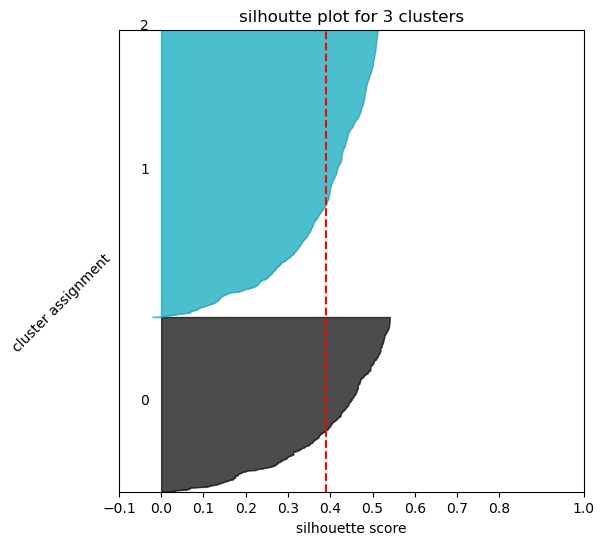

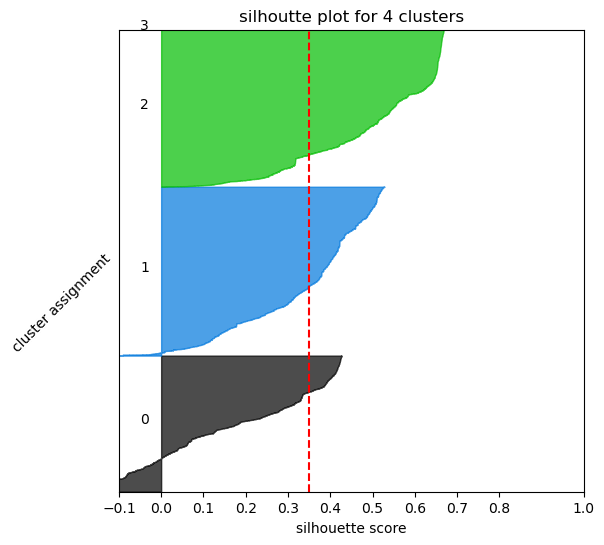

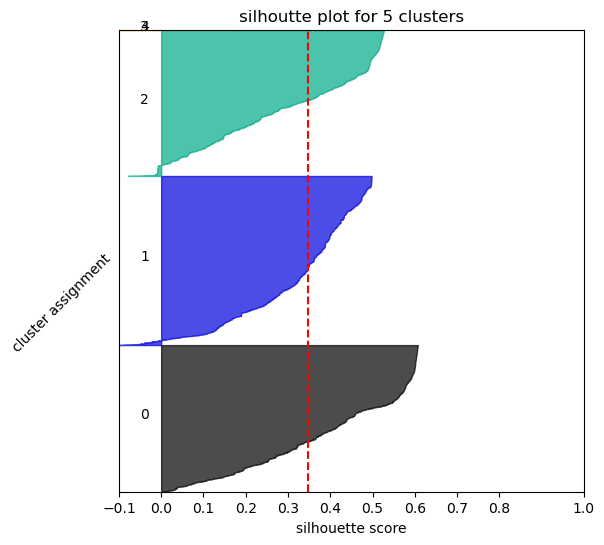

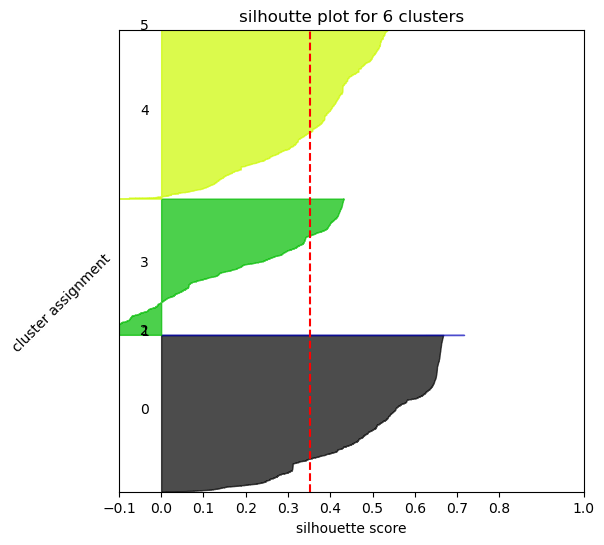

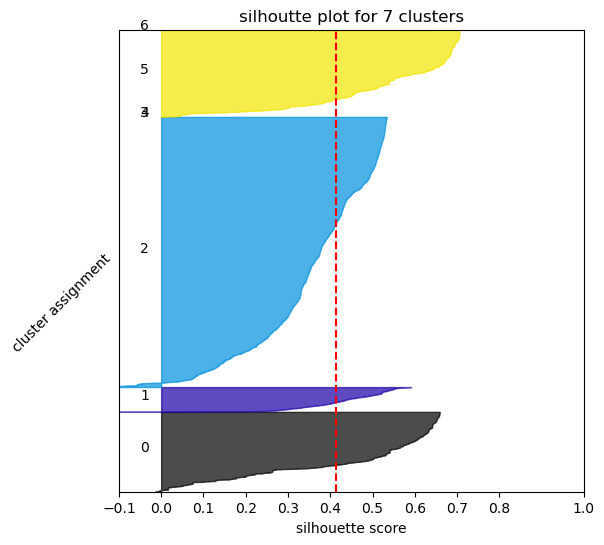

In [93]:
model_dict = {}
number_clusters_to_try = [3, 4, 5, 6, 7]
df_cluster_scaled = scale_data(df_cluster, sample_fraction = .25)
for number_clusters in number_clusters_to_try:
    df_cluster_scaled, df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, number_clusters)
    
    model_dict.update({number_clusters : kmeans_model})
    
    silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

### It appears that three clusters produces both a relatively high average silhouette score while also providing a good distribution for the individual silhouette scores. I will select the model corresponding to a K of 3 and assign the rest of the cluster labels to the data using predict.

In [336]:
df_label = df_cluster.copy()
df_label.loc[:, 'label'] = model_dict[3].predict(pd.DataFrame(StandardScaler().fit_transform(df_cluster), columns = df_label.columns))

In [337]:
df_label.to_csv('./kickstarter-sentiment-analysis_3-labeled-data-frame.csv', index = False)

In [287]:
df_label.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd,label
0,230.0,11,1.238278,6746.0,3.0,2475.318022,8353.424400,1
1,34.0,11,1.238278,1079.0,3.0,247.655630,1336.102124,1


## 3.0 Analyzing Results

### I will use the clustering results to mine the data. I will first look at patterns within the clusters using the numerical data. After that I will do a word frequency analysis of each cluster to gain some insight from that dimension of the data.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import pickle
import ast

## 3.1 Numerical Analysis

## I will define a custom plotting function, using matplotlib, that will allow me to plot numerical data in a histogram and categorical data in a barplot.

In [3]:
# Here I define a plotting function where I can look at histograms or bar plots of the features within each cluster.

def custom_plot(data, feature, plotType = 'hist', number_clusters = 3, sharex = True, 
                number_columns = 3, round_digits = 2, figsize = (24, 8), number_bins = 60,
                xbounds = [], ybounds = [], fontfamily = 'arial', fontweight = 'bold', fontsize = 20, top_n = 0):

    font = {'family' : fontfamily,
            'weight' : fontweight,
            'size'   : fontsize}

    matplotlib.rc('font', **font)
    
    number_rows = int(np.ceil(number_clusters/number_columns));
    fig, axs = plt.subplots(nrows = number_rows, ncols = number_columns, figsize = figsize, layout = 'constrained')
    fig.suptitle(feature + " by cluster", x = 0.0);
    
    if (plotType == 'hist'):
        for index, ax in enumerate(axs):
            hist_data = data.loc[data['label'] == index , :]
            hist_data = hist_data.loc[:, feature].values;
            
            mean = np.mean(hist_data)
            std = np.std(hist_data)
            
            hist_data = [i for i in hist_data if (i <= mean + 2 * std) and (i >= mean - 2 * std)]
                         
            if xbounds:
                hist_data = [i for i in hist_data if (i >= xbounds[index][0]) and (i <= xbounds[index][1])]
                mean = np.mean(hist_data)
                std = np.std(hist_data)
            
            color = cm.nipy_spectral(float(index/number_clusters))                          
            ax.hist(hist_data, number_bins, facecolor = color, edgecolor = 'k', alpha = 0.7)                           
            
            ax.tick_params(rotation = 45, labelsize = fontsize)
            ax.set_title("cluster {} \n mean of ".format(index) + feature + " = {:.1f} (red) \n".format(mean));
      
            ax.set_xlabel(feature, fontsize = fontsize)
            ax.set_ylabel('counts', fontsize = fontsize)             
            
            ax.set_xticks(ax.get_xticks());
            ax.set_yticks(ax.get_yticks());
            
            ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');
            ax.set_yticklabels(ax.get_yticklabels(), va = 'top');          
            
            if ybounds:
                ylims = ybounds[index];
            else:
                ylims = ax.get_ylim();
            
            ax.vlines(mean, ylims[0], ylims[1], colors = 'r')
            
            ax.set_ylim(bottom = ylims[0], top = ylims[1]);
            
    elif (plotType == 'bar'):
        for index, ax in enumerate(axs):
            bar_data = sorted(data.loc[data['label'] == index, feature].values)
    
            feature_type_count = {};
            for value in bar_data:
                if value not in feature_type_count.keys():
                    feature_type_count.update({value : 1});
                else:
                    feature_type_count[value] += 1;
    
            sorted_feature_type_count = sorted(feature_type_count.items(), key = lambda x : x[1], reverse = True)
            if top_n != 0:
                feature_type_count = dict(sorted_feature_type_count[0:top_n]);
                percent_data_accounted_for = round(100*(sum([i[1] for i in sorted_feature_type_count[0:top_n]])/sum([i[1] for i in sorted_feature_type_count]))) 
            else:
                feature_type_count = dict(sorted_feature_type_count);
                percent_data_accounted_for = 100.0;
    
            keys = feature_type_count.keys();
            values = feature_type_count.values();
    
            color = cm.nipy_spectral(float(index/number_clusters))    
            ax.bar(keys, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')
    
            ax.tick_params(rotation = 45, labelbottom = True, labelsize = fontsize)
            ax.set_title("cluster {} \n top_n = {} \n {} % of data accounted for".format(index, top_n, percent_data_accounted_for));          
        
            ax.set_xlabel(feature, fontsize = fontsize)
            ax.set_ylabel('counts', fontsize = fontsize)
            
            ax.set_xticks(ax.get_xticks());
            ax.set_yticks(ax.get_yticks());
            
            ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');               
            ax.set_yticklabels(ax.get_yticklabels(), va = 'top');
                       
    return fig, axs

### I will read in the labeled data set and combine it with the sentence data so that I can use the language data later.

In [4]:
df_label = pd.read_csv('./kickstarter-sentiment-analysis_3-labeled-data-frame.csv')

In [5]:
df_mixed = pd.read_csv('./kickstarter-sentiment-analysis_usd-preprocessed-with-sentences.csv').dropna()

In [6]:
df_mixed.loc[:, 'label'] = np.nan;
for index, row in df_mixed.iterrows():
    if index in df_label.index:
        df_mixed.loc[index, 'label'] = df_label.loc[index, 'label']

### One of the metrics I am interested in is how much a campaign recieved (pledged_usd) compared to what it's goal (goal_usd) was. So, I will calculate the difference of these two and assign it to a new field.

In [7]:
df_mixed.loc[:, 'pledged-goal'] = df_mixed['pledged_usd'] - df_mixed['goal_usd']

In [8]:
df_mixed.head(2)

,backers_count,category,fx_rate,state,sentences,goal_usd,pledged_usd,label,pledged-goal
0,230.0,Software,1.238278,successful,"['cisco', 'ccna', 'and', 'ccna', 'security', '...",2475.318022,8353.424400,1.0,5878.106378
1,34.0,Software,1.238278,successful,"['strong', 'file', 'encryption', 'tool', 'stro...",247.655630,1336.102124,1.0,1088.446494


### I first will look at the difference of pledged_usd - goal_usd. It appears that the three clusters represent three general types of campaigns from the perspective of this metric. 

#### Cluster 0: campaigns in this cluster generally recieved less money than they sought by an average of about $16000. These are almost all failed campaigns

#### Cluster 1: campaigns in this cluster revieved an average of $2400 more dollars than they asked for. The are generall all successfull, however ther are a few campaigns here that are not yet successfulthough not necessarily failed; they could just be in progress at the present time.

#### Cluster 2: campaigns in this cluster recieved wildly less money than they asked for. These gampaigns were probably way too optimistic about how much money they could raise. There are only a few entries in this category releative to the others, however the recieved an average of almos 70 million less than they asked for. These were placed in their own group by the clustering algorithm because they are outliers.

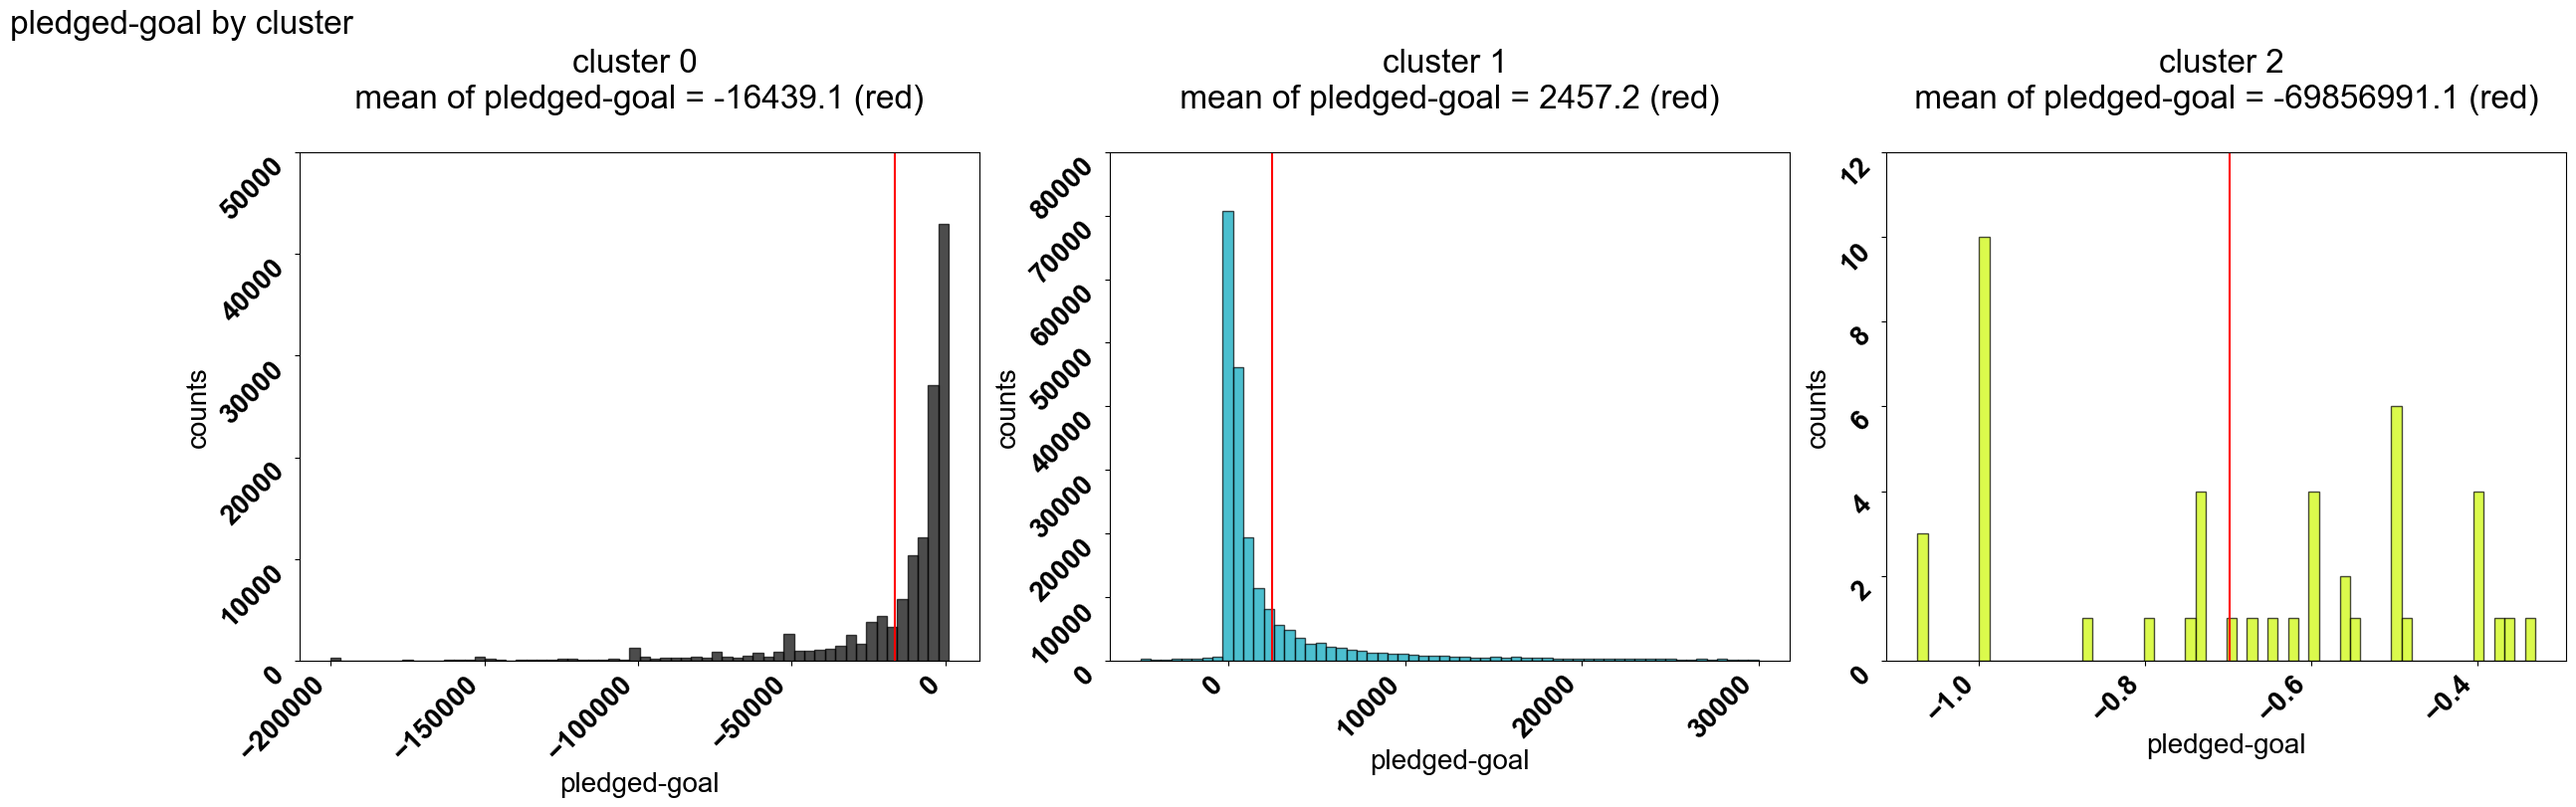

In [9]:
fig1, axs1 = custom_plot(df_mixed, 'pledged-goal' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(-200000, .01e5), (-5000, 30000), (-1.1e8, 0)], fontsize =  20)

### Next I will look at the amount of money pledged for each of the three clusters.

#### Cluster 0: This cluster, which I know from the previous plots, corresponds to failed campaigns, has an average pledge of just over $300. This makes sense given that they are almost all failed.

#### Cluster 1: Cluster 1, in contrast to Cluster 0, has an average pledge of just over $12000. This makes sense given that this cluster corresponds mostly to successfull campaigs.

#### Cluster 2: This cluster, which is the outlier clusters, has the worst average pledge amount of the three; on average, only just under $26.

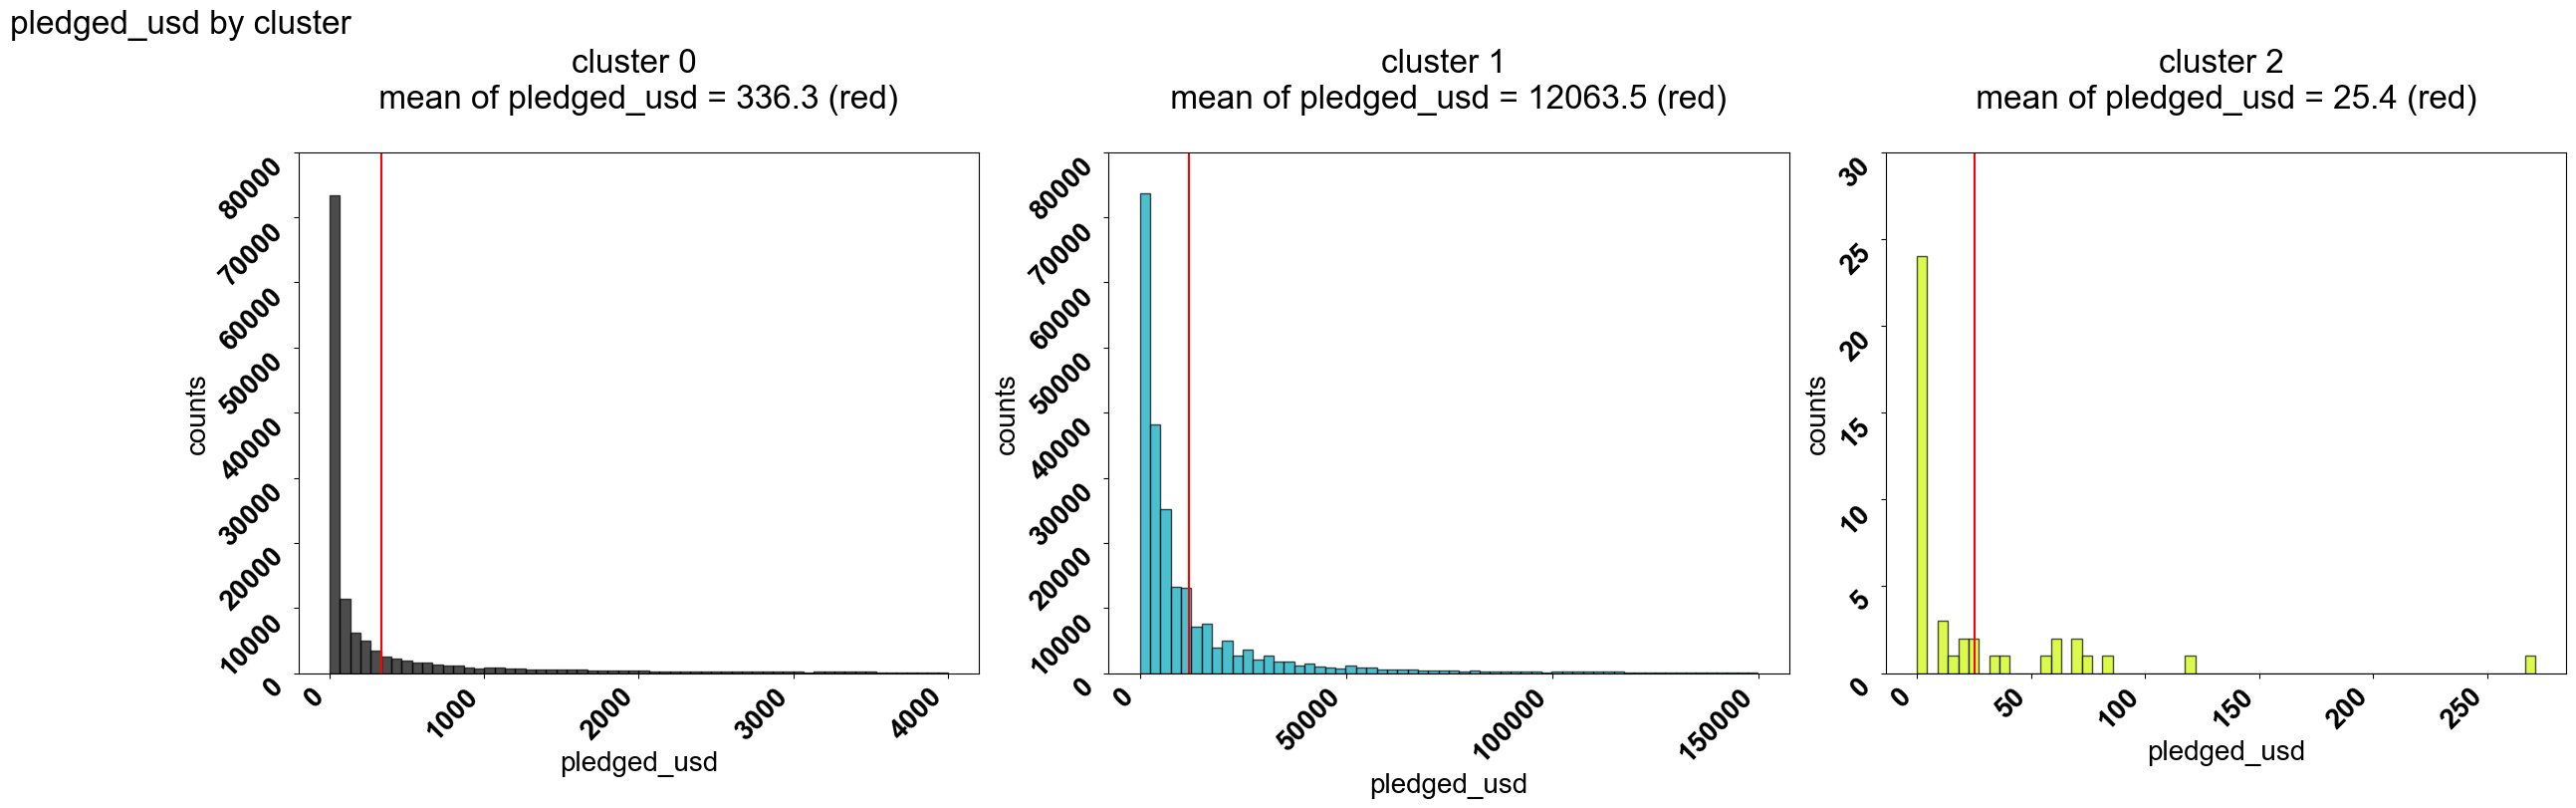

In [10]:
fig2, axs2 = custom_plot(df_mixed, 'pledged_usd' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 4000), (0, 150000), (0, 400)], fontsize = 20)

### Next I will look at the goal, how much each campaign asked for.

#### Cluster 0: This cluster of failed campaigns has an asking goal of almost $20000

#### Cluster 1: The successfull cluster shows a much more modest goal of about $8000.

#### Cluster 2: The outlier cluster once again shows a crazy average asking goal a of almost $70000000. Clearly kickstarer pledges were unconvinced by this steep price tag. 

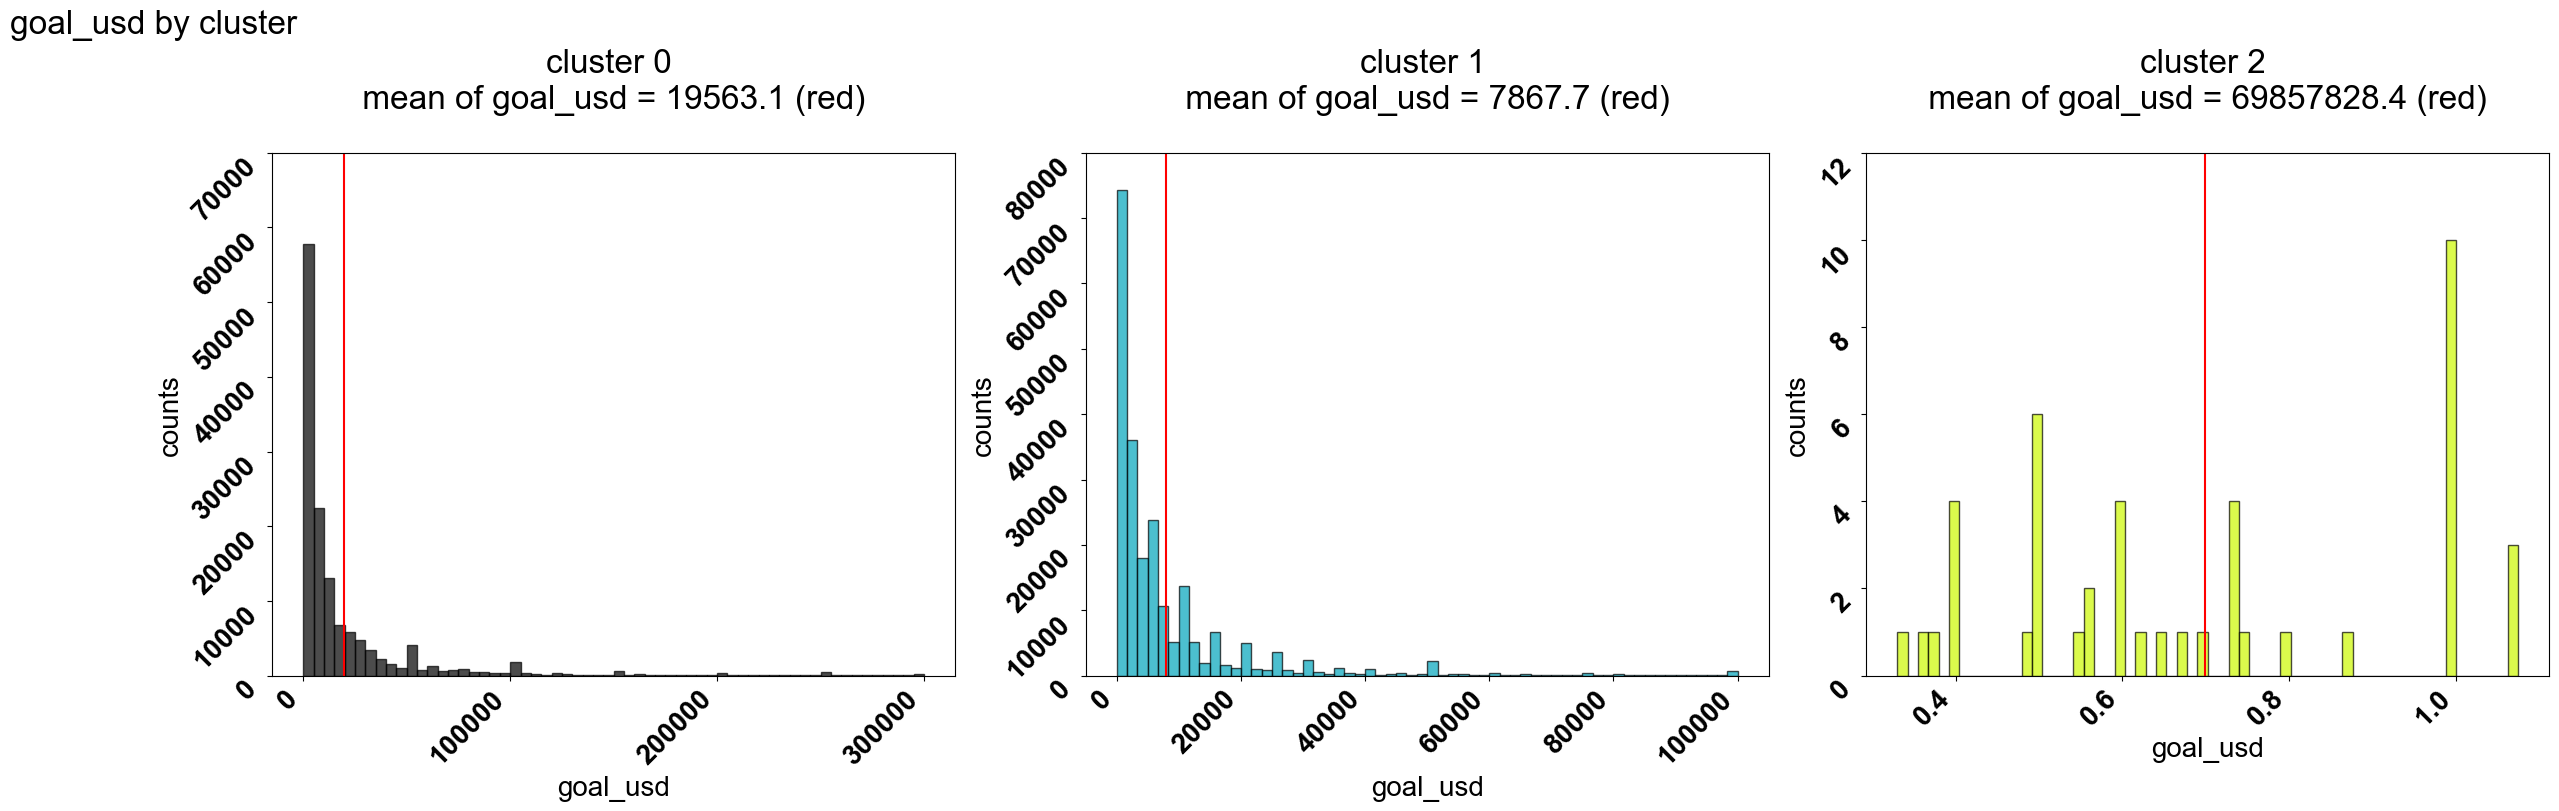

In [11]:
fig3, axs3 = custom_plot(df_mixed, 'goal_usd' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, .3e6), (0, 100000), (0, 1.1e8)], fontsize = 20)

#### Next I'll look at the distribution of backers in the three clusters.

#### Cluster 0: The underperforming cluster with mostly failed campaigns has less than 100 backers generally, with a mean of just under 8 backers.

#### Cluster 1: In contranst the successfull cluster has many more backers, with an average of almost 152.

#### Cluster 2: The outlier cluster has the fwest backers with a mode of 1 backer and an average of 1.8 backers.

#### Apparently successfull campaigns tend to occurr with hundreds of backers, not a few backers contributing the sum amount for the campaign. A good rule of thumb might be that you should aim for a couple hundred backers to secure a successfull campaign.

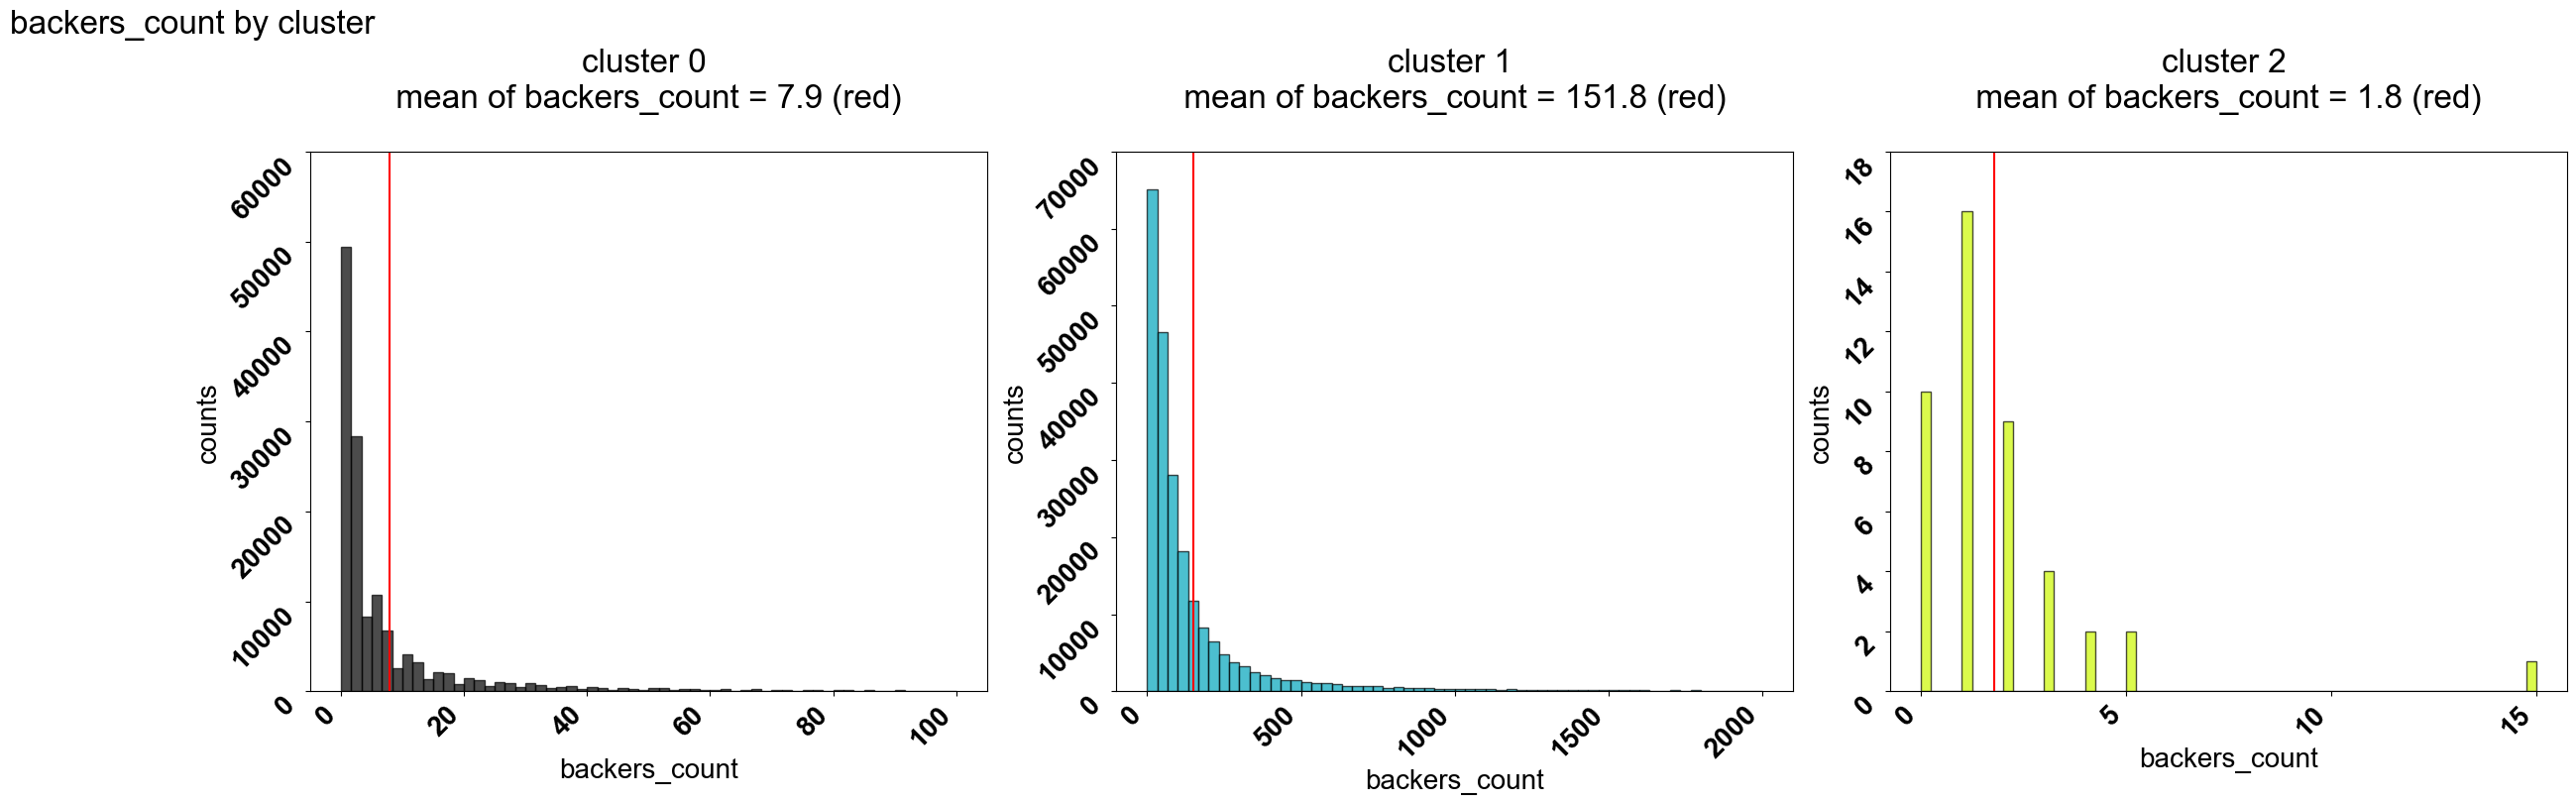

In [12]:
fig4, axs4 = custom_plot(df_mixed, 'backers_count' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 20)

#### Next I will plot the distribution for the states of each  cluster.

#### Cluster 0: This underperperforming cluster, predictably, is dominated by failed campaigns. The next most numerous category are canceled campaings. There are some submitted campaigns as well.

#### Cluster 1: This overperforming cluster is, again predictably, dominated by successful campaigns. The next most are live and submitted.

#### Cluster 2: The outlier cluster is dominated by failed and canceled campaigs, as well as a few live ones.

#### As for the submitted and live campaigns in the underperforming cluster, based on their associated with other failed campaigns in this cluster, I would not expect them to be successful, just as I would expect the same for those two categories in Cluster 2. However I would expect success from the live and submitted campaigns in Cluster 1, based on THEIR association with that cluster.

#### An interesting further analysis would be to compare the canceled live and submitted campaigns between the three cluster to see similarities and differences. The conclusions from this further analysis might inform the best way to conduct one's own campaign.

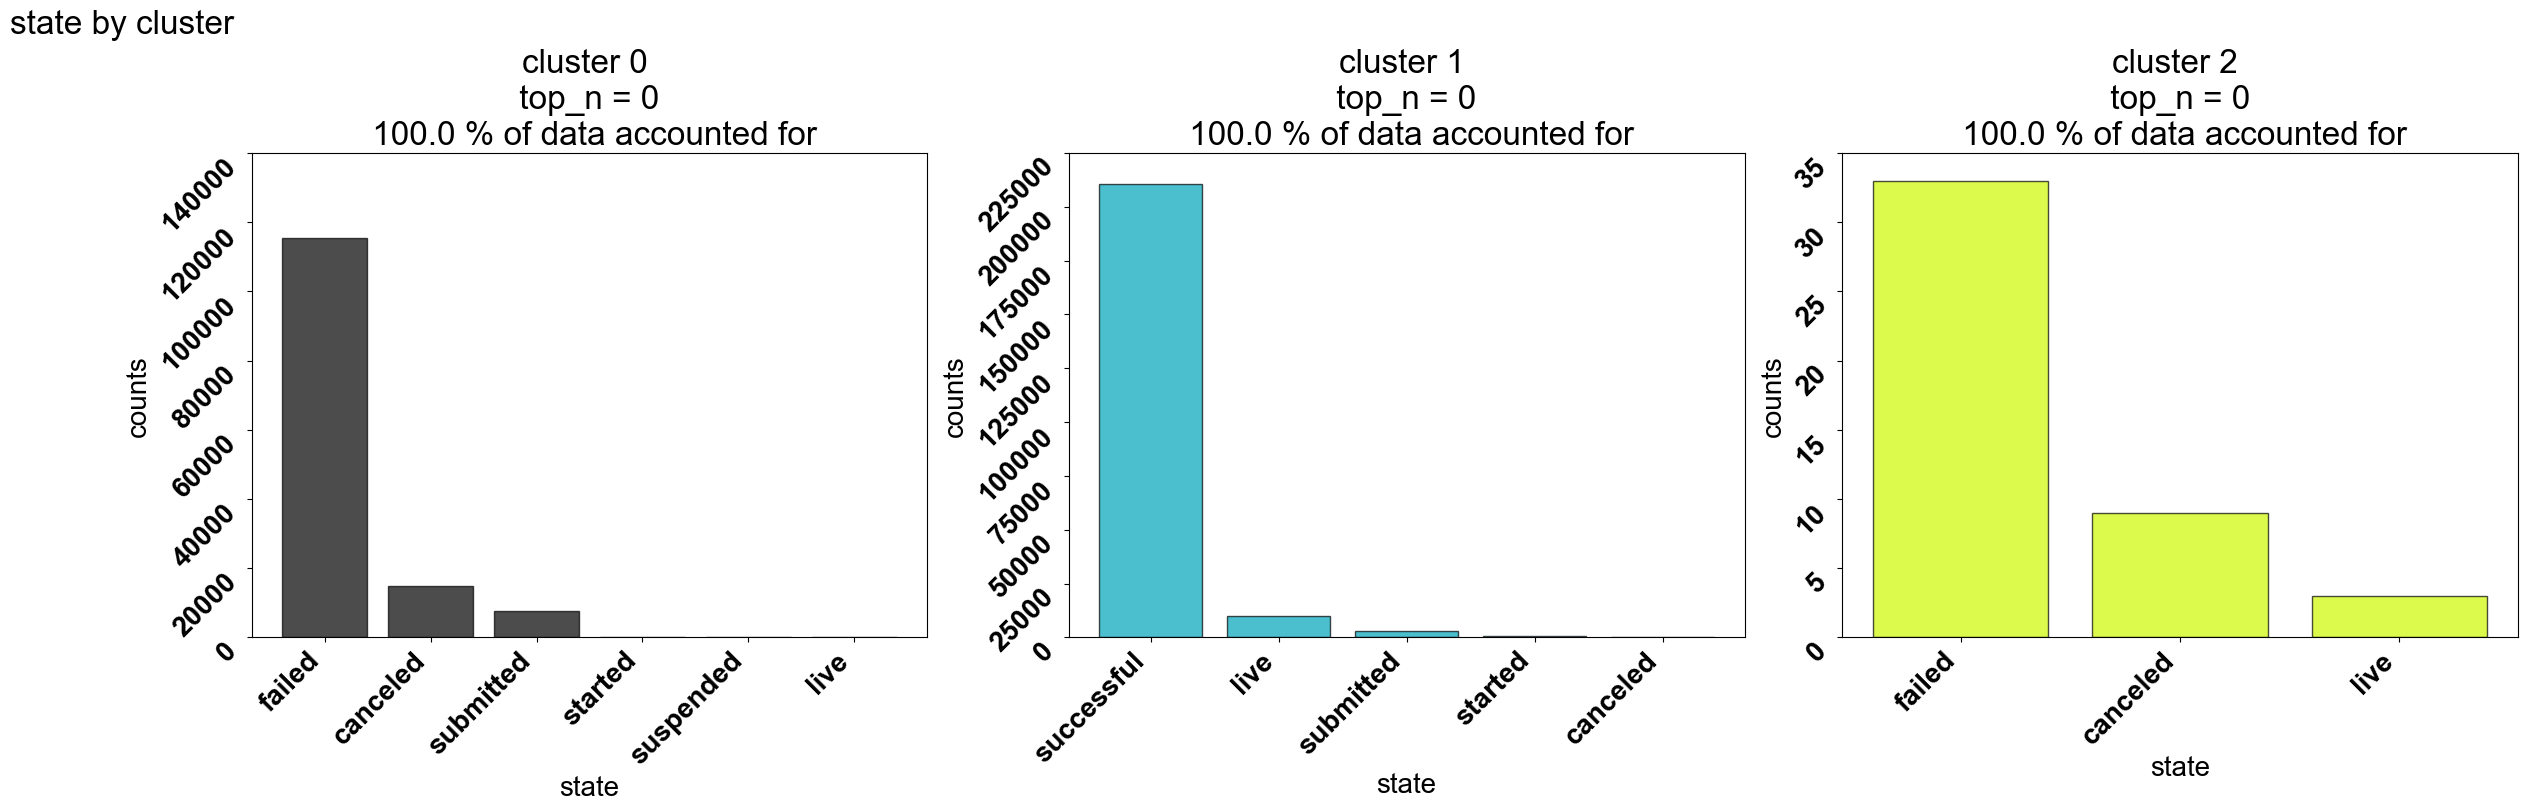

In [13]:
fig4, axs4 = custom_plot(df_mixed, 'state' ,plotType = 'bar', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 20)

#### Lastly, for this section, I will plot the top 30 most frequent product categories for campaigns within each of the three clusters. I will look at the top two such categories to draw some initial conclusions.

#### The underperforming clusters, dominated by failed campaigns, have the highest failure rates for Software and Web development, in Cluster 0, and for Space Exploration and Television, in Cluster 2. 

#### Cluster 0: One immediate reason why Software and Web projects may be unattractive is a problem of scope. More specifically these projects applications may be targeted at a niche audience and so need an alternate funding strategy, like croudfunding, to have a chance of further development -- generally software and web development don't have too much trouble finding funding from traditional investment sources. The high failure rate of these projects might suggest that the audience for these projects is prohibitively small.

#### Cluster 2: Developing a televsision show is probably out of the scope of what is capable with croudfunding and this is doubly so for exploring space. This outlier cluster also has a problem with scope, however in a slightly different way from Cluster 0. In this cluster the ambition of the two greatest failed categories is likely too large to be successful. Users likely find this unattractive.

#### The successful cluster, Cluster 1, has a top two categories that are inline with a medium scope of production amibition and general audience. Designing a new product for personal use often times involves getting an initial stock of product manufactured. This can often be done, working with a manufacturer overseas, for several to tens of thousands of dollars -- a common size for kickstarter campaigns. Secondly, Fiction, in the form of a novel, short story series, or even short film, is a descrete consumable product that a broad array of people may enjoy without paying too high a price for it.

#### I believe the differences in categories here reflects the importance of scoping a campaign on kickstarter properly.

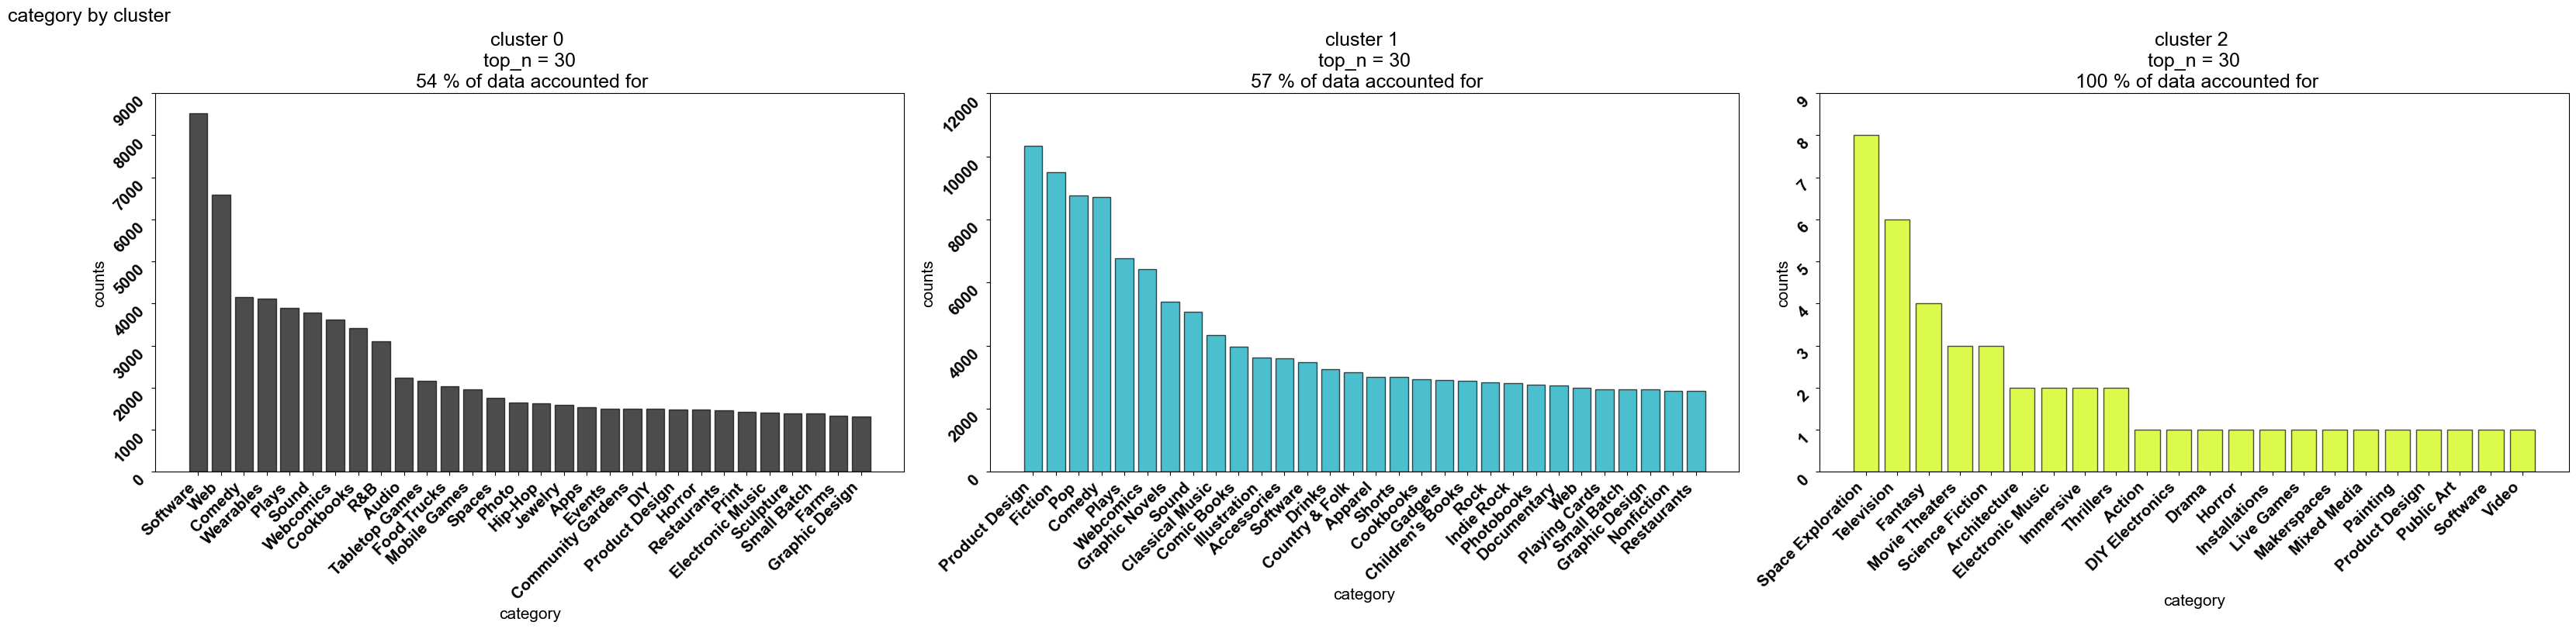

In [14]:
fig4, axs4 = custom_plot(df_mixed, 'category' ,plotType = 'bar', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (32, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 15, top_n = 30)

## 3.2 Word Frequency by Cluster

 #### Now I'm going to do a word frequency analysis for each of the three clusters. 

#### This cell will calculate the word frequencies for each cluster and store these in a dictionary called word_frequencies. I am using a standard nested dictionary counting method for this.

In [15]:
word_frequencies = {}
labels = list(df_mixed['label'].unique());
for index, row in df_mixed.iterrows():
    sentence = [i.strip() for i in ast.literal_eval(row['sentences'])];
    if row['label'] not in word_frequencies.keys():
        word_frequencies.update({row['label'] : {}});
        for word in sentence:
            if word not in word_frequencies[row['label']].keys():
                word_frequencies[row['label']].update({word : 1});
            else:
                word_frequencies[row['label']][word] += 1;
                
    else:
        for word in sentence:
            if word not in word_frequencies[row['label']].keys():
                word_frequencies[row['label']].update({word : 1});
            else:
                word_frequencies[row['label']][word] += 1;

#### I am going to pickle and save this so that I don't have to redo the fequency count
#### later.

In [16]:
with open('./kickstarter-sentiment-analysis_word-frequencies.pickle', 'wb') as handle:
    pickle.dump(word_frequencies, handle);

#### Here I will define a plotting function that plots the top_n most frequent words for each cluster. I am going to import gensims STOPWORDS frozen list to use as a referenceto exclude stop words.

In [17]:
from gensim.parsing.preprocessing import STOPWORDS as stopwords
custom_stopwords = ['new'];

def custom_word_frequency_plot(word_frequencies, number_columns = 3, figsize = (24, 8), top_n = 0, fontsize = 20):
    
    cluster_labels = word_frequencies.keys();
    number_clusters = len(cluster_labels);
    
    number_rows = int(np.ceil(number_clusters/number_columns));
    fig, axs = plt.subplots(nrows = number_rows, ncols = number_columns, figsize = figsize, layout = 'constrained');
    
    for index, ax in enumerate(axs):
        
        # remove any stopwords using the filter function.
        filtered_words = filter(lambda x : (x[0] not in stopwords) and (x[0] not in custom_stopwords), word_frequencies[index].items())
        sorted_words = sorted(filtered_words, key = lambda x : x[1], reverse = True)
        if top_n > 0:
            sorted_words = sorted_words[0:top_n];
        unzipped = list(zip(*sorted_words));
        
        words = unzipped[0];
        values = unzipped[1];
        
        color = cm.nipy_spectral(float(index/number_clusters))    
        ax.bar(words, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')
        
        ax.tick_params(rotation = 45, labelbottom = True, labelsize = fontsize)
        ax.set_title("cluster {}".format(index));          
        
        ax.set_xlabel('words', fontsize = fontsize)
        ax.set_ylabel('counts', fontsize = fontsize)
            
        ax.set_xticks(ax.get_xticks());
        ax.set_yticks(ax.get_yticks());
            
        ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');               
        ax.set_yticklabels(ax.get_yticklabels(), va = 'top');
        
    return fig, axs

#### The data here are less conclusive than above however looking at the top most frequent word in each cluster I see more evidence of influence of scope in the success or failure of a project.

#### Cluster 0: The word, "help" is the most frequent word in this cluster. This may fit with the category emphasis of this cluster being software and web development: i.e. software products that are productivity or educational tools. If this is the case it points to problem of an audience that is too small to fully fund the project.

#### Cluster 1: "Album," is the most frequent word in cluster 1. Albums are descrete consumable products that are not prohibitively expensive to create. They make for a good product to run a campaign for on kickstarter.

#### Cluster 2: "Move" and, "film" are the top two words in the outlier cluster. While movies have a broad audience and can generally afforded by anyone, they can be very expensive to make. Given the other information I have displayed about this cluster, it is likely that the movies pitched were unreasonably ambitious to be taken seriously by backers.

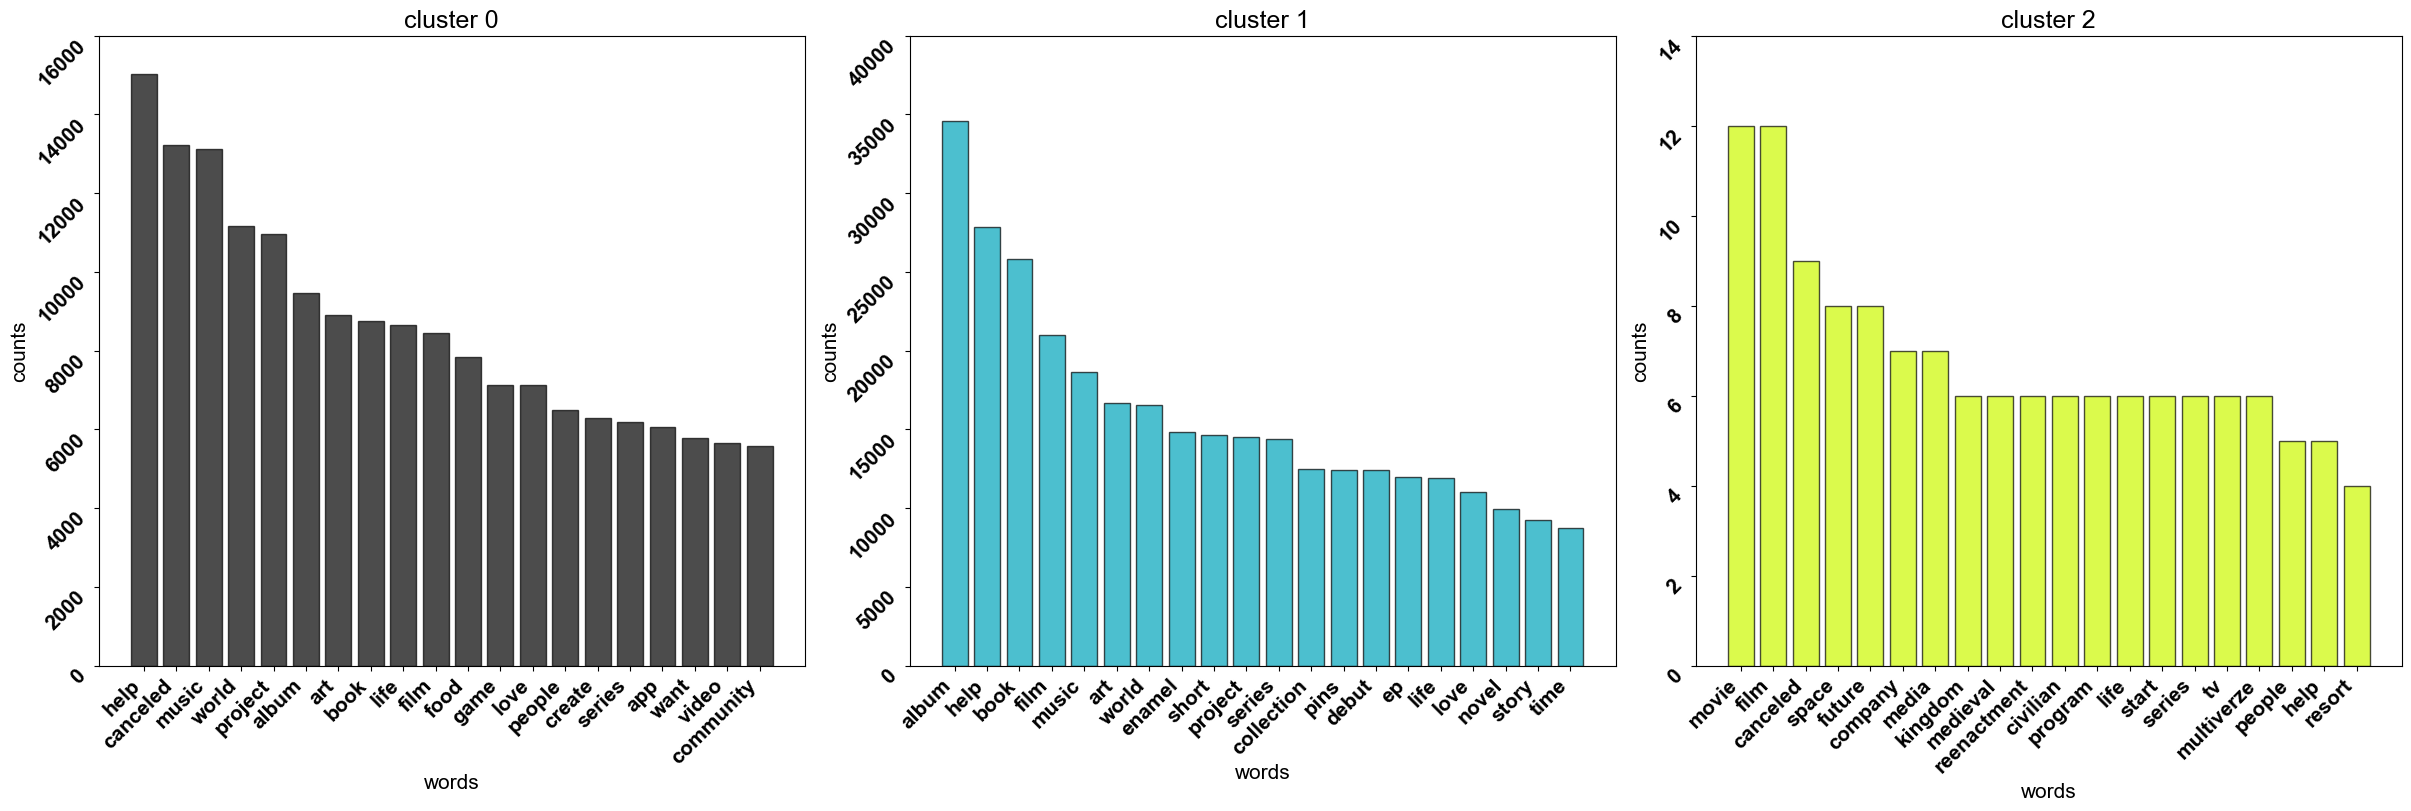

In [18]:
custom_word_frequency_plot(word_frequencies, number_columns = 3, figsize = (24, 8), top_n = 20, fontsize = 15);